In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Import dataset

In [2]:
data = pd.read_csv('house_sales.csv')
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3.0,1.00,1180.0,5650.0,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3.0,2.25,2570.0,7242.0,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2.0,1.00,770.0,10000.0,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4.0,3.00,1960.0,5000.0,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3.0,2.00,1680.0,8080.0,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


Describe the dataset. 

In [3]:
data.shape

(21613, 21)

There are 21,613 rows and 21 columns. 

In [4]:
data.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.161300e+04,2.161300e+04,20479.000000,20545.000000,20503.000000,2.056900e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,4.580302e+09,5.400881e+05,3.372821,2.113507,2081.073697,1.517982e+04,1.494309,0.007542,0.234303,3.409430,7.656873,1788.390691,291.509045,1971.005136,84.402258,98077.939805,47.560053,-122.213896,1986.552492,12768.455652
std,2.876566e+09,3.671272e+05,0.930711,0.768913,915.043176,4.148617e+04,0.539989,0.086517,0.766318,0.650743,1.175459,828.090978,442.575043,29.373411,401.679240,53.505026,0.138564,0.140828,685.391304,27304.179631
min,1.000102e+06,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.219500e+05,3.000000,1.500000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471000,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1920.000000,7.620000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.070800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,12050.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


Check for nulls. 

In [5]:
data.isna().sum()

id                  0
date                0
price               0
bedrooms         1134
bathrooms        1068
sqft_living      1110
sqft_lot         1044
floors              0
waterfront          0
view                0
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated        0
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

bedrooms, bathrooms, sqft_living, and sqft_lot contain nulls.  

What is the difference between sqft_living and sqft_living15? What about sqft_loft and sqft_loft15? The fields appended with "15" don't have any nulls. 

# Check for outliers. 

Let's start with the date column

In [6]:
columns_with_outliers = set() 

In [7]:
type(data.date[0])

str

The values in the date column are strings. We should convert them to dates. 

In [8]:
data['date'] = data.apply(lambda row: pd.to_datetime(row.date), axis=1)
data['date']

0       2014-10-13
1       2014-12-09
2       2015-02-25
3       2014-12-09
4       2015-02-18
           ...    
21608   2014-05-21
21609   2015-02-23
21610   2014-06-23
21611   2015-01-16
21612   2014-10-15
Name: date, Length: 21613, dtype: datetime64[ns]

In [9]:
data['date'] = data['date'].dt.date
data['date']

0        2014-10-13
1        2014-12-09
2        2015-02-25
3        2014-12-09
4        2015-02-18
            ...    
21608    2014-05-21
21609    2015-02-23
21610    2014-06-23
21611    2015-01-16
21612    2014-10-15
Name: date, Length: 21613, dtype: object

In [10]:
data.date.min(), data.date.max()

(datetime.date(2014, 5, 2), datetime.date(2015, 5, 27))

All of the dates are within 2014 and 2015, as expected. Let's move on to price. 

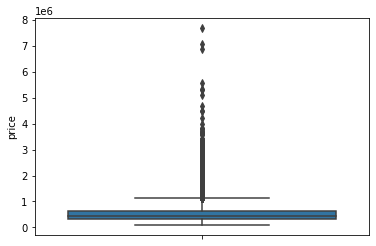

In [11]:
sns.boxplot(data=data, y='price')
plt.show()

There are many price outliers that right-skew the distribution. Let's add it to our set of columns with outliers. And look at bedrooms. 

In [12]:
columns_with_outliers.add('price')

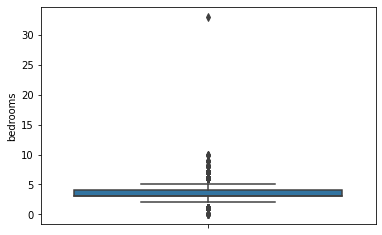

In [13]:
sns.boxplot(data=data, y='bedrooms')
plt.show()

There are bedrooms outliers so let's add it to our set and look at bathrooms. 

In [14]:
columns_with_outliers.add('bedrooms')

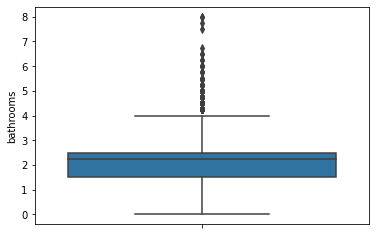

In [15]:
sns.boxplot(data=data, y='bathrooms')
plt.show()

There are bathrooms outliers so let's add it to our set and look at sqft_living.

In [16]:
columns_with_outliers.add('bathrooms')

Let's now take a look at sqft_living. 

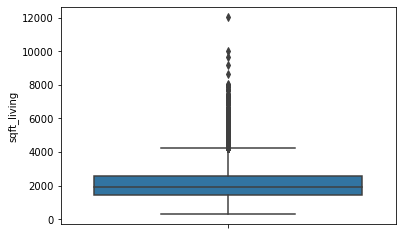

In [17]:
sns.boxplot(data=data, y='sqft_living')
plt.show()

There are sqft_living outliers so let's add it to our set and look at sqft_lot. 

In [18]:
columns_with_outliers.add('sqft_living')

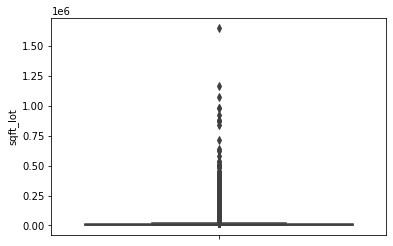

In [19]:
sns.boxplot(data=data, y='sqft_lot')
plt.show()

This distribution is extremely right-skewed with many outliers. Let's add it to our set and look at floors.

In [20]:
columns_with_outliers.add('sqft_lot')

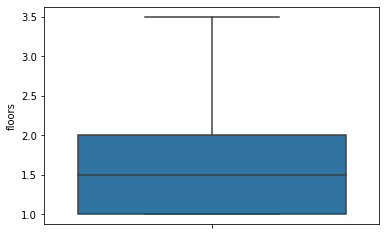

In [21]:
sns.boxplot(data=data, y='floors')
plt.show()

There are no floors outliers so let's move on. waterfront is a binary variable with a max of 1 so no outliers there. view is supposed to be a binary variable but the max is 4, so it must have some data errors. 

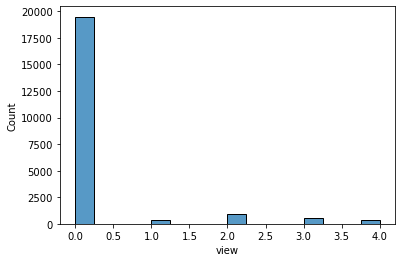

In [22]:
sns.histplot(data.view)
plt.show()

Some view values are 2, 3, and 4. Let's add this to our set but make sure we treat it differently when it comes time to identify outliers. 

In [23]:
columns_with_outliers.add('view')

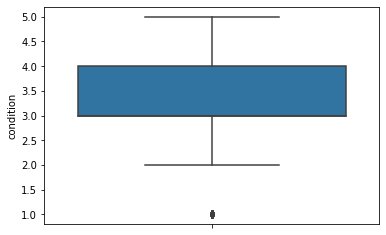

In [24]:
sns.boxplot(data=data, y='condition')
plt.show()

Condition has outliers so let's add it to our set and look at sqft_above.

In [25]:
columns_with_outliers.add('condition')

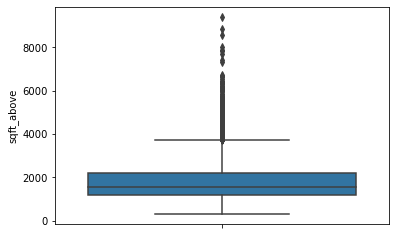

In [26]:
sns.boxplot(data=data, y='sqft_above')
plt.show()

sqft_above has outliers so let's add it to our set and look at sqft_basement.

In [27]:
columns_with_outliers.add('sqft_above')

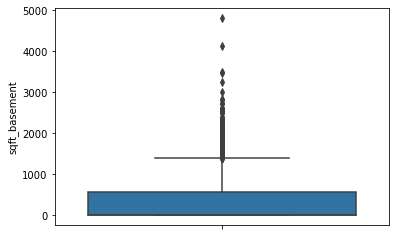

In [28]:
sns.boxplot(data=data, y='sqft_basement')
plt.show()

sqft_basement has outliers so let's add it to our set and look at yr_built.

In [29]:
columns_with_outliers.add('sqft_basement')

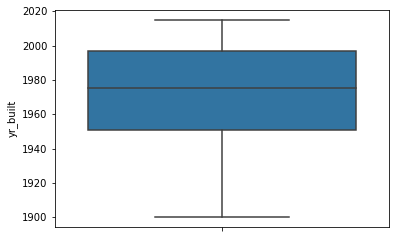

In [30]:
sns.boxplot(data=data, y='yr_built')
plt.show()

No yr_built outliers. Let's look at yr_renovated. Homes that have not been renovated have a value of 0. Let's replace these with nulls so they don't skew the distribution. 

In [31]:
data.yr_renovated.replace(0, np.nan, inplace=True)

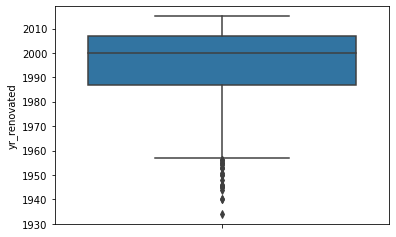

In [32]:
sns.boxplot(data=data, y='yr_renovated')
plt.show()

There are some outliers so let's add this to our set and look at zipcode. 

In [33]:
columns_with_outliers.add('yr_renovated')

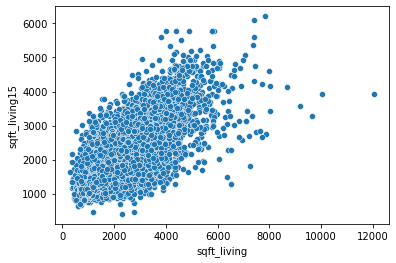

In [34]:
sns.scatterplot(data=data, x='sqft_living', y='sqft_living15')
plt.show()

No zipcode outliers so let's move on to sqft_living15. 

In [35]:
data.sqft_living.corr(data.sqft_living15)

0.7569012475423504

It has outliers so let's add it to our set and look at sqft_lot15. 

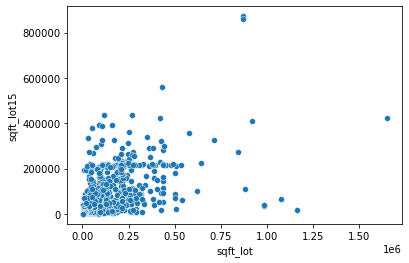

In [36]:
sns.scatterplot(data=data, x='sqft_lot', y='sqft_lot15')
plt.show()

There are some very extreme outliers so let's add this column to our set as well. 

In [37]:
columns_with_outliers.add('sqft_lot15')

In [38]:
columns_with_outliers

{'bathrooms',
 'bedrooms',
 'condition',
 'price',
 'sqft_above',
 'sqft_basement',
 'sqft_living',
 'sqft_lot',
 'sqft_lot15',
 'view',
 'yr_renovated'}

In [39]:
def get_outliers(column):
    if column == 'view':
        return data[data.view > 1]
    q1 = data[column].quantile(.25) 
    q3 = data[column].quantile(.75)
    iqr = q3 - q1
    return data[(data[column] < q1 - 1.5 * iqr) | (data[column] > q3 + 1.5 * iqr)]

In [40]:
def consolidate_outliers(columns): 
    outlier_dfs = [] # list to store the dataframe with each column's outliers 
    for c in columns: # for each column 
        df = get_outliers(c) # get its outliers as a dataframe
        outlier_dfs.append(df) # add that dataframe to the list 
    return pd.concat(outlier_dfs).drop_duplicates() # vertically combine the dataframes and drop duplicate rows

In [41]:
outliers = consolidate_outliers(columns_with_outliers)
outliers.shape

(5186, 21)

Our consolidated, deduped dataframe of outliers from all columns has 4,348 houses. Let's remove them from our dataset. 

In [42]:
data.sqft_lot.corr(data.sqft_lot15)

0.7287996812850762

sqft_lot and sqft_lot15 are also quite strongly positively correlated, with a coefficient of 0.73. 

Create df of rows with null sqft_living and sqft_lot to use later.

In [43]:
nullsqft_living = data['sqft_living'].isnull()
null_living = pd.DataFrame(data['sqft_living15'][nullsqft_living])

nullsqft_lot = data['sqft_lot'].isnull()
null_lot = pd.DataFrame(data['sqft_lot15'][nullsqft_lot])

Create a data set of data without outliers and where sqft_living and sqft_lot are non-empty
Use this set for regression analysis

In [44]:
filtereddata = data.dropna(subset = ['sqft_living', 'sqft_lot'])
filtereddata.shape[0]

19506

# Start regression analysis

Sqft_lot based on sqft_lot15

In [45]:
from statsmodels.formula.api import ols
from statsmodels.sandbox.regression.predstd import wls_prediction_std
model = ols("sqft_lot ~ sqft_lot15", data=filtereddata).fit()
modelsummary = model.summary()
print (modelsummary)

                            OLS Regression Results                            
Dep. Variable:               sqft_lot   R-squared:                       0.526
Model:                            OLS   Adj. R-squared:                  0.526
Method:                 Least Squares   F-statistic:                 2.166e+04
Date:                Tue, 06 Apr 2021   Prob (F-statistic):               0.00
Time:                        22:54:36   Log-Likelihood:            -2.2783e+05
No. Observations:               19506   AIC:                         4.557e+05
Df Residuals:                   19504   BIC:                         4.557e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1045.8609    225.895      4.630      0.0

In [46]:
data['sqft_lot'] = data.apply(
    lambda row:
        .9877*row.sqft_lot15+207.8945
    if np.isnan(row.sqft_lot) else row.sqft_lot, axis=1)

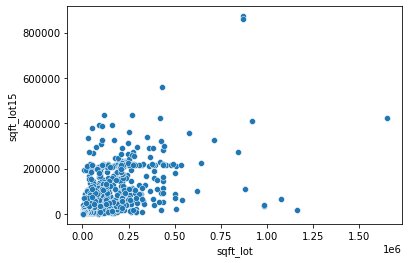

0.7329440768300777

In [47]:
sns.scatterplot(data=data, x='sqft_lot', y='sqft_lot15')
plt.show()
data.sqft_lot.corr(data.sqft_lot15)

We see our coefficient and intercept matches the scatter plot above

sqft_living based on sqft_living15

In [48]:
import statsmodels
from statsmodels.formula.api import ols
from statsmodels.sandbox.regression.predstd import wls_prediction_std
model = ols("sqft_living ~ sqft_living15", data=filtereddata).fit()
modelsummary = model.summary()
print (modelsummary)

                            OLS Regression Results                            
Dep. Variable:            sqft_living   R-squared:                       0.573
Model:                            OLS   Adj. R-squared:                  0.573
Method:                 Least Squares   F-statistic:                 2.621e+04
Date:                Tue, 06 Apr 2021   Prob (F-statistic):               0.00
Time:                        22:54:38   Log-Likelihood:            -1.5239e+05
No. Observations:               19506   AIC:                         3.048e+05
Df Residuals:                   19504   BIC:                         3.048e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        74.7375     13.114      5.699

In [49]:
data['sqft_living'] = data.apply(
    lambda row:
        1.0140*row.sqft_living15+66.5914
    if np.isnan(row.sqft_living) else row.sqft_living, axis=1)

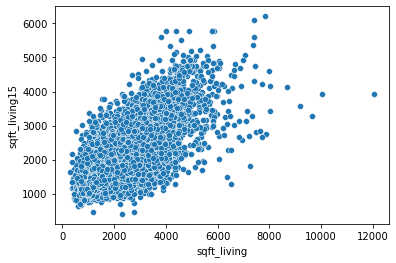

0.7653446902881086

In [50]:
sns.scatterplot(data=data, x='sqft_living', y='sqft_living15')
plt.show()
data.sqft_living.corr(data.sqft_living15)

In [51]:
data.isna().sum()

id                   0
date                 0
price                0
bedrooms          1134
bathrooms         1068
sqft_living          0
sqft_lot             0
floors               0
waterfront           0
view                 0
condition            0
grade                0
sqft_above           0
sqft_basement        0
yr_built             0
yr_renovated     20699
zipcode              0
lat                  0
long                 0
sqft_living15        0
sqft_lot15           0
dtype: int64

There are no null sqft_living or sqft_lot records anymore.